# <u>Sentiment Classification</u>
*Sentiment Classification is the task of looking at a piece of text and telling if someone likes or dislikes the thing they're talking about.*
### Project Description
**Generate Word Embeddings and retrieve outputs of each layer with Keras based on the Classification task**

Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation.
It is a distributed representation for the text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging natural language processing problems.<br/>
We will use the IMDb dataset to learn word embeddings as we train our dataset. This dataset contains 25,000 movie reviews from IMDB, labeled with a sentiment (positive or negative).
### Dataset
**`from keras.datasets import imdb`**

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, the words are indexed by their frequency in the dataset, meaning for that has index 1 is the most frequent word. Use the first 20 words from each review to speed up training, using a max vocab size of 10,000.

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.


### Goal of the project
1. Import test and train data
2. Import the labels ( train and test)
3. Get the word index and then Create a key-value pair for word and word_id
4. Build a Sequential Model using Keras for the Sentiment Classification task
5. Report the Accuracy of the model
6. Retrieve the output of each layer in Keras for a given single test sample from the trained model you built
---

## Imports and Configurations

In [1]:
# Utilities
from time import time
import itertools
import warnings

# Numerical calculation
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sequential Modeling
import keras.backend as K
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Embedding, LSTM, TimeDistributed, Conv1D, MaxPooling1D
from keras.constraints import max_norm, unit_norm
from keras.preprocessing.sequence import pad_sequences

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_recall_curve

Using TensorFlow backend.


In [2]:
# Configure for any default setting of any library
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

## Loading the dataset

In [3]:
# Load IMDB Data
vocab_size = 10000 #vocab size

# save np.load
old = np.load

# modify the default parameters of np.load to allow_pickle to avoid the following error:
# ValueError: Object arrays cannot be loaded when allow_pickle=False
np.load = lambda *a,**k: old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
imdb_data = imdb.load_data(num_words=vocab_size)

# restore np.load for future normal usage and delete the old
np.load = old
del(old)

## Train test split

train_data  (25000,)
train_labels  (25000,)
__________________________________________________
test_data  (25000,)
test_labels  (25000,)
__________________________________________________
Minimum value of a word index : 1
Maximum value of a word index : 9999
Maximum number of words of review in train : 2494
Minimum number of words of review in train : 11
Maximum number of words of review in test  : 2315
Minimum number of words of review in test  : 7


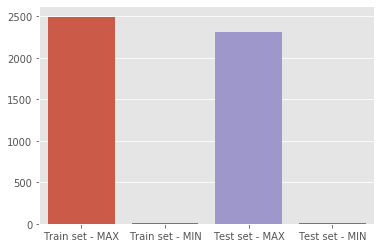

In [4]:
#load dataset as a list of ints
(train_data, train_labels), (test_data, test_labels) = imdb_data

print("train_data ", train_data.shape)
print("train_labels ", train_labels.shape)
print("_"*50)
print("test_data ", test_data.shape)
print("test_labels ", test_labels.shape)
print("_"*50)
print("Minimum value of a word index :", min([min(sequence) for sequence in train_data]))
print("Maximum value of a word index :", max([max(sequence) for sequence in train_data]))
train_len = [len(sequence) for sequence in train_data]
test_len = [len(sequence) for sequence in test_data]
print("Maximum number of words of review in train :", max(train_len))
print("Minimum number of words of review in train :", min(train_len))
print("Maximum number of words of review in test  :", max(test_len))
print("Minimum number of words of review in test  :", min(test_len))

# Visualize the length of max and min length reviews in both training and test sets
sns.barplot(x=['Train set - MAX','Train set - MIN','Test set - MAX','Test set - MIN'], 
            y=[max(train_len),min(train_len),max(test_len),min(test_len)])

#### Sentiment types

[0 1]


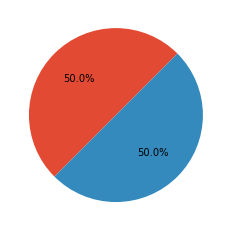

In [5]:
# The unique sentiments as target column
unique, counts = np.unique(np.concatenate((train_labels, test_labels)), return_counts=True)
print(unique)
sentiments = {1: 'Positive', 0: 'Negative'}

# Visualize the propertion of Positive and Negative reviewes in the original dataset
_ = plt.pie(counts, autopct='%1.1f%%', startangle=45)

## Interpete the actual Reviews

In [6]:
# Reverse from integers to words using the DICTIONARY (given by keras...need to do nothing to create it)
def interprete_review(sequence):
    id_to_word = dict([(value, key) for (key, value) in imdb.get_word_index().items()])
    decoded_review = ' '.join([id_to_word.get(idx-3, '?') for idx in sequence])
    print(decoded_review)
    
review_id1 = np.random.choice(train_len)
interprete_review(train_data[review_id1])
print('\nThe sentiment for the above review is:', sentiments.get(train_labels[review_id1]))
print("_"*125)
review_id2 = np.random.choice(test_len)
interprete_review(test_data[review_id2])
print('\nThe sentiment for the above review is:', sentiments.get(test_labels[review_id2]))

? as a another reviewer states ? war is an outstanding film about an outstanding person ? ? ? who would become the jewish joan of arc unfortunately i ? in opinion not ? that miss ? as the lead is too beautiful to be taken seriously as a resistance fighter in truth for me her performance is not held back by her beauty but makes it all the more stark in the terror of the sadistic brutality as a ? she faces ? ? performance is brave poignant heartfelt or understood and totally believable in other words for me in the zone from the opening credits if you would like to learn about the suffering of someone else for something they believe in and be ? entertained give ? war with ? ? a try my hat is off also to ellen ? as ? mother a much well known and famous actress who could have made effort to walk off with the film in that it is a team effort perhaps of two ? but not an all about eve situation

The sentiment for the above review is: Positive
___________________________________________________

**Note:** In Keras format for movie reviews the words that are rare (not among the 10,000 most common) or aren't in the training data have a special ID value of 2. Also, each ID is offset by 3 to make room for special values 0, 1, 2 and 3. So is the reason for substracting 3 to find the correct word for an ID.

## Vectorize input data
Both train_data and test_data are in the form of 1D list of integers. They need to be converted into binary matrix in order to feed them into NN model. Besides all the reviews are NOT of same length. So we are using pad_sequences from keras to make all the reviews of same size by padding 0's before the sequence. 

**We're going to pad them to make them of equal size of 300 as per the question instead of considering the max length for padding to be 2494 which is the word count of highest length review.**

We'll also analyze how much portion of original data we're trimming off by considering 300 as the maxlen.

In [7]:
maxlen = 1500  #number of word used from each review
# maxlen = max([len(sequence) for sequence in np.concatenate([train_data, test_data])])

#make all sequences of the same length
x_train = pad_sequences(train_data, maxlen=maxlen)
x_test =  pad_sequences(test_data, maxlen=maxlen)

y_train = train_labels
y_test = test_labels

print("x_train :", x_train.shape)
print("x_test  :", x_test.shape)

x_train : (25000, 1500)
x_test  : (25000, 1500)


In [8]:
# Visualize any random review after padding
x_train[np.random.randint(0,len(train_data)-1)]

array([  0,   0,   0, ..., 676, 496,  12])

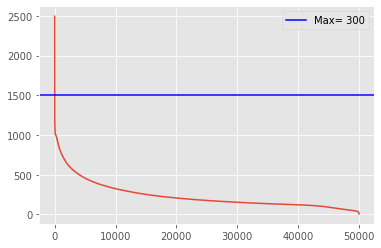

In [9]:
# Plot the max word count of all 50,000 reviews
imdb_len = [len(sequence) for sequence in np.concatenate((train_data,test_data))]
plt.plot(np.sort(imdb_len)[::-1])
plt.axhline(maxlen, color='b', label='Max= 300')
plt.legend()

In [10]:
print('Trimming off %.2f%% of data by setting 300 as maxlen' % (len([i for i in imdb_len if i > maxlen]) / len(imdb_len) * 100))

Trimming off 0.02% of data by setting 300 as maxlen


**Observations**:
- From the above figure and the calculation it is found out that by setting maxlen to 300, we're trimming off almost $\frac{1}{5}^{th}$ of original review data
---
## Build Keras Sequential Model
We can think of the Embedding layer as a dicionary that maps a index assigned to a word to a word vector. This layer is very flexible and can be used in a few ways:

* The embedding layer can be used at the start of a larger deep learning model. 
* Also we could load pre-train word embeddings into the embedding layer when we create our model.
* Use the embedding layer to train our own word2vec models.

The keras embedding layer doesn't require us to onehot encode our words, instead we have to give each word a unqiue intger number as an id. For the imdb dataset we've loaded this has already been done, but if this wasn't the case we could use sklearn [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

#### Generic Methods
Let's write some generic method to plot some useful curves such as validation curves, precision-recall curves and print the classification summary.

In [11]:
# Generic method to plot the VALIDATION curves
def plot_validation_curve(history, metrics):
    plt.clf()
    history_dict = history.history
    f, ax = plt.subplots(1, len(metrics), figsize=(16,6))
    for i, metric in enumerate(metrics):
        metric_values = history_dict[metric]
        val_metric_values = history_dict['val_' + metric]
        epochs = range(1, (len(history_dict[metric]) + 1))
        ax[i].plot(epochs, metric_values, 'bo:', label='Training ' + metric)
        ax[i].plot(epochs, val_metric_values, 'go-', label='Validation ' + metric)
        ax[i].set_title('Training and Validation ' + ('Accuracy' if metric=='acc' else 'Loss'))
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Accuracy' if metric=='acc' else 'Loss')
        ax[i].legend()

In [12]:
# Generic method to plot Precision-Recall curve
def plot_prec_recall_vs_thresh(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend()

In [13]:
# Generic method to print the classification report
def classification_summary(y_test, y_pred, y_proba):
    print('\033[1mTesting accuracy:\033[0m %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('_'*80)
    print('\033[1mConfusion matrix:\033[0m\n %s' % (confusion_matrix(y_test, y_pred)))
    print('_'*80)
    print('\033[1mClassification report:\033[0m\n %s' % (classification_report(y_test, y_pred)))
    print('_'*80)
    print('\033[1mPrecision-Recall curve\033[10m')
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    plot_prec_recall_vs_thresh(precision, recall, thresholds)

Let's try for different flavors of Neural Networks to observe their performances with sequential textual data.
### Phase I - With Simple Artificial Neural Network (ANN)
The first deep learning model that we are going to develop is a simple deep neural network.

In [14]:
embedding_dim = 300
# Build the network
ann = Sequential()
ann.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
ann.add(Flatten())
ann.add(Dense(1, activation='sigmoid'))
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 300)         3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 450000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 450001    
Total params: 3,450,001
Trainable params: 3,450,001
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Train the model
epochs = 5
batches = 512
start = time()
history = ann.fit(x_train, y_train, epochs=epochs, batch_size=batches, validation_split=0.2)
print('Time spent: %.2f sec' % (time()-start))




Train on 20000 samples, validate on 5000 samples
Epoch 1/5





20000/20000 [==============================] - 3s 154us/step - loss: 1.1167 - acc: 0.5073 - val_loss: 0.6482 - val_acc: 0.7028
Epoch 2/5
20000/20000 [==============================] - 2s 78us/step - loss: 0.4945 - acc: 0.8046 - val_loss: 0.3750 - val_acc: 0.8538
Epoch 3/5
20000/20000 [==============================] - 2s 78us/step - loss: 0.2446 - acc: 0.9173 - val_loss: 0.2917 - val_acc: 0.8818
Epoch 4/5
20000/20000 [==============================] - 2s 78us/step - loss: 0.1509 - acc: 0.9561 - val_loss: 0.2773 - val_acc: 0.8836
Epoch 5/5
20000/20000 [==============================] - 2s 78us/step - loss: 0.0951 - acc: 0.9810 - val_loss: 0.2772 - val_acc: 0.8860
Time spent: 9.54 sec


<Figure size 432x288 with 0 Axes>

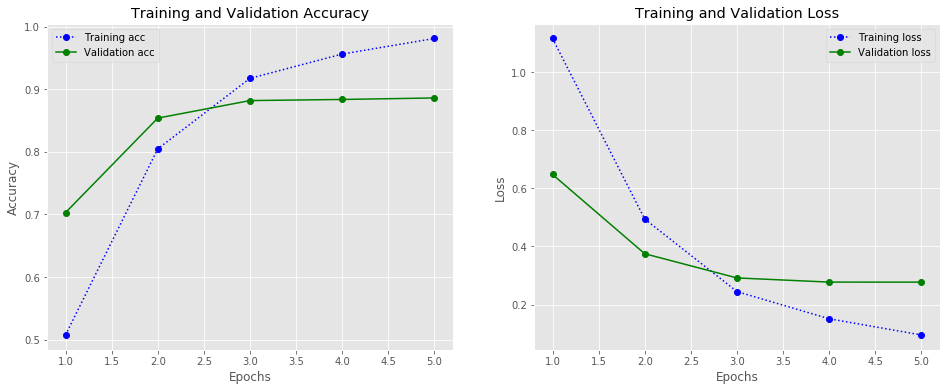

In [16]:
# VALIDATION ACCURACY and LOSS Curve
plot_validation_curve(history, ['acc','loss'])

In [17]:
# Find Loss and Accuracy of test set
loss, acc = ann.evaluate(x_test, y_test)
print("Test Loss: %.4f and Accuracy: %.2f%%" % (loss, acc * 100))

25000/25000 [==============================] - 3s 111us/step
Test Loss: 0.2808 and Accuracy: 88.18%


#### Analyze Classification Summary

Testing accuracy: 88.18%
________________________________________________________________________________
Confusion matrix:
 [[10845  1655]
 [ 1301 11199]]
________________________________________________________________________________
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88     12500
           1       0.87      0.90      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

________________________________________________________________________________
Precision-Recall curve


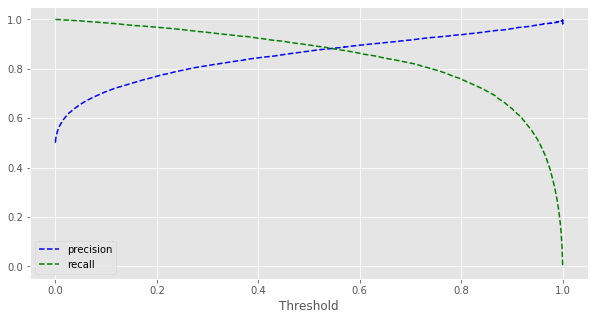

In [18]:
y_pred = ann.predict_classes(x_test)
y_proba = ann.predict_proba(x_test)
classification_summary(y_test, y_pred, y_proba)

**Observations**:
- ANN seems to be working good 88.2% test score.
- However, we can clearly see the differences for loss and accuracy between the training and validation sets. This indicates that the model is overfitted.

### Phase II - With Convolutional Neural Network (CNN)
Convolutional neural network is a type of network that is primarily used for 2D data classification, such as images. These networks also have been found to be working well with text data as well. Though text data is one-dimensional, we can use 1D convolutional neural networks to extract features from our data.<br/>
Let's create a simple convolutional neural network with 1 convolutional layer and 1 pooling layer.

In [21]:
# Build the network
cnn = Sequential()
cnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Dropout(0.2))
cnn.add(Flatten())
cnn.add(Dense(250, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1500, 300)         3000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1500, 300)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1500, 32)          28832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 750, 32)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 750, 32)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 24000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               6000250   
__________

In [22]:
# Train the model
epochs = 5
batches = 512
start = time()
history = cnn.fit(x_train, y_train, epochs=epochs, batch_size=batches, validation_split=0.2)
print('Time spent: %.2f sec' % (time()-start))

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 9s 427us/step - loss: 0.7093 - acc: 0.5104 - val_loss: 0.6859 - val_acc: 0.4940
Epoch 2/5
20000/20000 [==============================] - 8s 376us/step - loss: 0.5090 - acc: 0.7372 - val_loss: 0.3030 - val_acc: 0.8730
Epoch 3/5
20000/20000 [==============================] - 8s 376us/step - loss: 0.2331 - acc: 0.9063 - val_loss: 0.2662 - val_acc: 0.8948
Epoch 4/5
20000/20000 [==============================] - 8s 375us/step - loss: 0.1382 - acc: 0.9520 - val_loss: 0.2754 - val_acc: 0.8960
Epoch 5/5
20000/20000 [==============================] - 8s 376us/step - loss: 0.0897 - acc: 0.9709 - val_loss: 0.3135 - val_acc: 0.8916
Time spent: 38.91 sec


<Figure size 432x288 with 0 Axes>

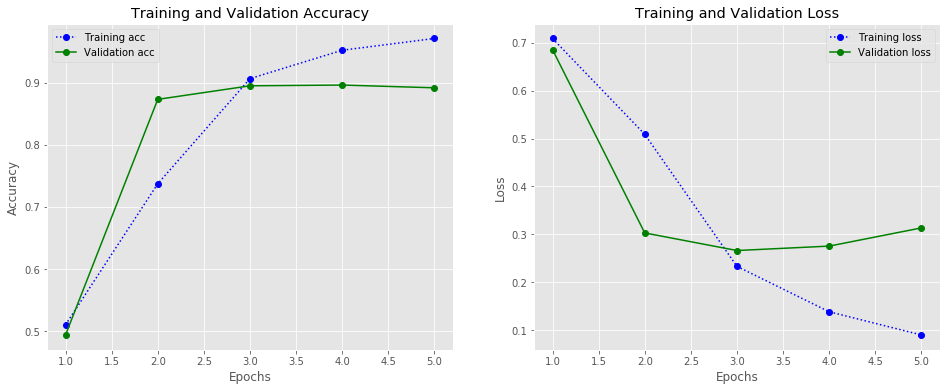

In [23]:
# VALIDATION ACCURACY and LOSS Curve
plot_validation_curve(history, ['acc','loss'])

In [24]:
# Find Loss and Accuracy of test set
loss, acc = cnn.evaluate(x_test, y_test)
print("Test Loss: %.4f and Accuracy: %.2f%%" % (loss, acc * 100))

25000/25000 [==============================] - 2s 97us/step
Test Loss: 0.3330 and Accuracy: 88.10%


Testing accuracy: 88.10%
________________________________________________________________________________
Confusion matrix:
 [[10972  1528]
 [ 1448 11052]]
________________________________________________________________________________
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

________________________________________________________________________________
Precision-Recall curve


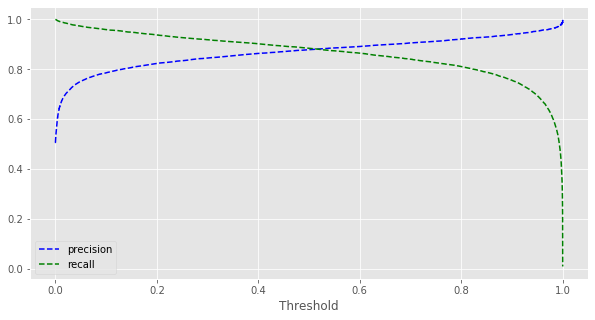

In [25]:
y_pred = cnn.predict_classes(x_test)
y_proba = cnn.predict_proba(x_test)
classification_summary(y_test, y_pred, y_proba)

**Observations**:
- CNN seems to be working badly though the test score is close to ANN.
- The significant deviation of accuracy and loss curves of validation set from test set indicates it is deviating from convergence.

### Phase III - With Recurrent Neural Network (LSTM)
Recurrent neural network is a type of neural networks that is proven to work well with sequence data. Since text is actually a sequence of words, a recurrent neural network is an automatic choice to solve text-related problems. In this section, we will use an LSTM (Long Short Term Memory network) which is a variant of RNN, to solve sentiment classification problem.

In [32]:
# Build the network
lstm = Sequential()
lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
lstm.add(Dropout(0.2))
lstm.add(LSTM(128, activation='tanh', dropout=0.2,
               kernel_constraint=unit_norm(),
               recurrent_constraint=unit_norm(),
               bias_constraint=unit_norm()))
lstm.add(Dense(150, activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1500, 300)         3000000   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1500, 300)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_12 (Dense)             (None, 150)               19350     
_________________________________________________________________
dropout_12 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 151       
Total params: 3,239,149
Trainable params: 3,239,149
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Train the model
epochs = 5
batches = 128
start = time()
history = lstm.fit(x_train, y_train, epochs=epochs, batch_size=batches, validation_split=0.2)
print('Time spent: %.2f sec' % (time()-start))

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 449s 22ms/step - loss: 0.5455 - acc: 0.7095 - val_loss: 0.3657 - val_acc: 0.8414
Epoch 2/5
20000/20000 [==============================] - 449s 22ms/step - loss: 0.2794 - acc: 0.8885 - val_loss: 0.3465 - val_acc: 0.8494
Epoch 3/5
20000/20000 [==============================] - 444s 22ms/step - loss: 0.2017 - acc: 0.9244 - val_loss: 0.3572 - val_acc: 0.8442
Epoch 4/5
20000/20000 [==============================] - 468s 23ms/step - loss: 0.1446 - acc: 0.9459 - val_loss: 0.4555 - val_acc: 0.8274
Epoch 5/5
20000/20000 [==============================] - 457s 23ms/step - loss: 0.1088 - acc: 0.9614 - val_loss: 0.5044 - val_acc: 0.8614
Time spent: 2267.72 sec


In [ ]:
# VALIDATION ACCURACY and LOSS Curve
plot_validation_curve(history, ['acc','loss'])

In [ ]:
# Find Loss and Accuracy of test set
loss, acc = lstm.evaluate(x_test, y_test)
print("Test Loss: %.4f and Accuracy: %.2f%%" % (loss, acc * 100))

In [ ]:
y_pred = lstm.predict_classes(x_test)
y_proba = lstm.predict_proba(x_test)
classification_summary(y_test, y_pred, y_proba)

**Observations**:
- The output shows that the difference between the accuracy and loss values for training and validation sets are much smaller compared to the simple neural network and CNN.
- Even though the test score is slightly less than the other two networks, just because this model is not overfitted, we can conclude, that for our problem, RNN is the best algorithm.
---
## Single Instance Prediction
Let's pull a single review from the imdb dataset and predict it's sentiment. Also predict the sentiment of a custom review.

In [29]:
# Predict for a random pre-defined review from IMDB dataset
review_id = np.random.choice(test_len)
interprete_review(test_data[review_id])
print('\nThe \033[1mACTUAL\033[0m sentiment    :\033[1m' + sentiments.get(test_labels[review_id]) + '\033[0m')
prediction = lstm.predict_classes(pad_sequences([test_data[review_id]], maxlen=maxlen))
print('\nThe \033[1mPREDICTED\033[0m sentiment :\033[1m' + sentiments.get(prediction[0][0]) + '\033[0m')

? it would be great if a discussion on this medium length film is ? with a brief tale about ? of hollywood people it was in 1988 that chuck norris saw this film at cannes international film festival he made a silly remark by ? that the senseless killing depicted in 5 is far more effective than killings which have been filmed in his hollywood films with him as a potent action star he was speaking about an innocent taxi driver whose face is brutally ? in ? film by a reckless psychopath who hits him ? with a big stone there should be absolutely no justification for violence and its ? in a ? human society this is the reason why chuck ? statement appears as a cruel joke which ? violent means in a society which is increasing becoming restless an honest reviewer would not be making a mistake if he she states that ? film 1 5 has universal ? this is because the events depicted in 5 can happen in any part of world the best lesson which gives to us concerns levels of violence which are acceptable

In [30]:
# Predict for a custom review not present in the IMDB dataset
review = '''This Movie should only be watched if you want to punish yourself by sitting through 3 hours of torture.
            Bland movie, extremely slow, boring, monotonous with weak and predictable story with dose of overacting'''
word_dict = imdb.get_word_index()
words = review.split()
review = []
for word in words:
    if word.lower() not in word_dict:
        review.append(2)
    else:
        review.append(word_dict[word.lower()] + 3) 

**Note:** The Keras format for movie reviews expects all lower-case letters, with all punctuations removed except the single-quote character. The dictionary is 1-base indexed and constructed by word frequency. For example, word_dict["the"] = 1, word_dict["and"] = 2.<br/>
The words that are rare (not among the 10,000 most common) or aren't in the training data have a special ID value of 2. Also, each ID is offset by 3 to make room for special values 0, 1, 2 and 3. So is the reason for adding 3 to generate the intgers list for a review.

In [31]:
prediction = lstm.predict_classes(pad_sequences([review], maxlen=maxlen))
print('\nThe PREDICTED sentiment for this custom review:\033[1m', sentiments.get(prediction[0][0]))


The PREDICTED sentiment for this custom review: Negative


**Observation**:
- As we can see the model is predicting pretty well for pre-defined reviews as well as for any custom review that is not in IMDB dataset, even if it is sarcastic.
---
## Retrive the output of each layer in keras for a given single test sample from the trained model you built
Let's create a generic method to print the name, size and output of each layer in Keras model.

In [32]:
def layer_outs_for_single_instance(model, instance):
    outputs = [layer.output for layer in model.layers]                  # all layer outputs
    function = K.function([model.input, K.learning_phase()], outputs)   # evaluation function
    
    if instance.any():
        layer_outs = function([np.array([instance,]), 1.])
        print('_'*75)
        for idx, out in enumerate(layer_outs):
            print('\033[1mLayer# :', idx + 1)
            print('\033[1mName   :', model.layers[idx].name)
            print('\033[1mShape  : ' + str(out.shape) + '\033[0m')
            print(out)
            print('_'*75)

**NOTE:**<br/>
`K.function` creates TensorFlow tensor functions which are later used to get the output from the symbolic graph given the input. The model builds the predict function using `K.function`.<br/>
Now `K.learning_phase()` is required as an input as many Keras layers like Dropout/Batchnomalization depend on it to change behavior during training and test time.

More reference from the following link: [The output of an intermediate layer in Keras](https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer)

In [33]:
layer_outs_for_single_instance(lstm, x_test[np.random.choice(test_len)])

___________________________________________________________________________
Layer# : 1
Name   : embedding_3
Shape  : (1, 1500, 100)
[[[ 0.03510366 -0.00104784 -0.03768963 ... -0.04661006  0.03081103
   -0.01086194]
  [ 0.03510366 -0.00104784 -0.03768963 ... -0.04661006  0.03081103
   -0.01086194]
  [ 0.03510366 -0.00104784 -0.03768963 ... -0.04661006  0.03081103
   -0.01086194]
  ...
  [ 0.02757719  0.02297452  0.04802293 ...  0.04535711  0.03242543
   -0.02364207]
  [ 0.02750194 -0.00705909 -0.03055361 ... -0.0072977  -0.03107705
   -0.0766234 ]
  [ 0.02527129  0.0090374  -0.02742705 ... -0.0208643   0.03123565
   -0.04808005]]]
___________________________________________________________________________
Layer# : 2
Name   : lstm_1
Shape  : (1, 128)
[[ 0.0894258  -0.14665581  0.06511226  0.01985266  0.0790855  -0.04832412
   0.04911081 -0.08062933  0.01172083 -0.12288991  0.12251399  0.10662539
   0.05560811 -0.05968403  0.0477291   0.18705608  0.06837336 -0.02814982
  -0.02717827  0.03